###### Cloud Cover (cl) 
### Below 700 hPa (lowest part of the atmosphere)

In [1]:
%matplotlib inline
import sys
sys.path.append('./scripts')

import datetime
import glob

#from joblib import Parallel, delayed
import multiprocessing

# OS interaction
import os
import pickle as pickle
import sys
import time
from copy import copy

import cartopy.crs as ccrs
import cftime
import dask
import dask.bag as db
import IPython.core.display as di  # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# Plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.axes_size as Size
import netCDF4 as nc

# netcdf/numpy/xarray
import numpy as np
import numpy.ma as mak
import numpy.matlib
import pandas as pd
import scipy as sp
import scipy.io as sio

# import spharm
import xarray as xr
from cartopy.util import add_cyclic_point
from IPython.display import HTML, display

# from matplotlib.gridspec import GridSpec
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
# import brewer2mpl as cbrew
from matplotlib import gridspec, ticker
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
from numpy import ma
from scipy import interpolate, stats
from shapely.geometry.polygon import LinearRing
from sklearn import linear_model
from windspharm.standard import VectorWind

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.ticker as mticker

In [2]:
# colours
violet = np.array([207,156,255])/255
fushia = np.array([209, 20, 232])/255
peri = np.array([71,168,237])/255

In [3]:
# make a new local mapping function that doesn't use basemap

def quick_map(mapdata,lat,lon,title=None,cb_ttl=None,cmap=None,clim=None,
              filepath=None,show=None,sigmask=None,p=None,
              do_zonal=None,
              outside_color = None, outside_val = None):
    
    if do_zonal==1:
        # make 2 subplots, one for map, one for zonal average next to it
        fig = plt.figure(figsize=(8,7))
    else: # Creates a map using the Robinson projection and draws coastlines.
        fig = plt.figure(figsize=(8,7))
    
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

    cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
    

    if cmap:
        plt.set_cmap(copy(cmap))
    else:
        plt.set_cmap(copy(plt.cm.viridis))
    
    if title:
        plt.title(title,fontsize=16,y=1.05)
        
    if clim:
        plt.cm.ScalarMappable.set_clim(cs,vmin = clim[0],vmax = clim[1])
        
    cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
    cbar.ax.tick_params(labelsize=14) 

    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=14)
    
    cm = plt.get_cmap()
   
    # add hatching for significance
    if p:
        cyclic_sig, cyclic_lons = add_cyclic_point(sigmask,coord=lon)
        #hatch = plt.pcolor(cyclic_lons,lat,cyclic_sig,hatch='xxx',alpha=0.,transform=ccrs.PlateCarree()); 

        CLN, CLT = np.meshgrid(cyclic_lons,lat)

        # only put the hatches where the sigmask is >0.5
        #cyclic_sig = np.ma.masked_where(cyclic_sig<p,cyclic_sig)
        sigmask = np.where(cyclic_sig>p,1.0,np.nan)
        sigmask2 = np.ma.masked_where(cyclic_sig > p, sigmask)
        
        lat_sig = np.ma.masked_where(cyclic_sig>p,CLT)
        lat_sig = np.ma.masked_where(np.isnan(cyclic_sig),lat_sig)
        lon_sig = np.ma.masked_where(cyclic_sig>p,CLN)
        lon_sig = np.ma.masked_where(np.isnan(cyclic_sig),lon_sig)

        hatch = ax.scatter(lon_sig,lat_sig,s=sigmask2,marker='x',#s=2,
                           c=[0.6, 0.6, 0.6],alpha=0.8,transform=ccrs.PlateCarree(),)

    ax.patch.set_alpha(0.0)
    
    
    # add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.xlocator = mticker.FixedLocator([])
    gl.ylocator = mticker.FixedLocator([-60,-30,0,30,60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 15, 'color': 'gray'}
    # gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
    
    if show:
        plt.show()
    
    if filepath:
        # save figure if path given
        fig.savefig(filepath+'.png',dpi=300,facecolor=None,edgecolor=None,bbox_inches='tight',transparent=True,pad_inches=0.01)
        fig.savefig(filepath+'.pdf',dpi=300,facecolor=None,edgecolor=None,bbox_inches='tight',transparent=True,pad_inches=0.01)
        
    plt.close()
    
    return fig,ax,cs,cbar,cm      

In [4]:
# sets up file paths and a list of model names used in a project analyzing C4MIP kernel data

# where C4MIP data is stored
path = '/arc/project/st-mlague-1/data/CMIP6'

# Set the path to save (no need for now): figdir = '/arc/project/st-mlague-1/data/CMIP6/'

# List all files or directories in the kernel data folder:
cmip_list = ['BCC','CCCma','CNRM-CERFACS','CSIRO','IPSL','MIROC','MOHC','MPI-M','NCAR','NOAA-GFDL']
cmip_exp_list = ['1pctCO2-bgc','1pctCO2-rad','1pctCO2']

In [5]:
cmip_dict = {}

for cmip_exp in cmip_exp_list:
    
    cmip_dict[cmip_exp] = {}
    
    if (cmip_exp == '1pctCO2'):
        cmip_path = path + "/CMIP"
    else:
        cmip_path = path + "/C4MIP"


    for center in cmip_list:

            print("center: ", center)

            cmip_dict[cmip_exp][center] = {}
            cl_files = []
            ds_list = []

            # ex. /arc/project/st-mlague-1/data/CMIP6/CMIP/BCC
            model_name = os.listdir(cmip_path + '/' + center)[0]
            # print("model_name: ", model_name)

            # ex. /arc/project/st-mlague-1/data/CMIP6/CMIP/BCC/1pctCO2/r1i1p1f1
            ensemble = os.listdir(cmip_path + '/' + center + '/' + model_name + '/' + cmip_exp)[0]
            # print("ensemble: ", ensemble)

            # ex. /arc/project/st-mlague-1/data/CMIP6/CMIP/BCC/1pctCO2/r1i1p1f1/Amon (or Lmon)
            domain = os.listdir(cmip_path + '/' + center + '/' + model_name + '/' + cmip_exp + '/' + ensemble)[1]
            # print("domain: ", domain)

            for var in ['cl']:

                # /arc/project/st-mlague-1/data/CMIP6/CMIP/BCC/1pctCO2/r1i1p1f1/Amon/cl
                model_path = cmip_path + '/' + center + '/' + model_name + '/' + cmip_exp  + '/' + ensemble + '/' + domain + '/' + var

                if not os.path.exists(model_path):
                    print(f"Variable path not found: {model_path}. Skipping...")
                    continue

                # ex. gn / gr
                grid = os.listdir(model_path)[0]
                # print("model_path: ", model_path)

                # ex. v20181015 (varies)
                version = os.listdir(model_path + '/' + grid)[0]
                # print("version: ", version)

                # /arc/project/st-mlague-1/data/CMIP6/CMIP/BCC/1pctCO2/r1i1p1f1/Amon/cl/gn/v20181015/cl
                file_path = model_path + '/' + grid + '/' + version + '/' + var
                # all files that end with .nc
                file_list = glob.glob(file_path+'/*.nc')

                if not file_list:
                    print(f"No .nc files found in: {file_path}. Skipping...")
                    continue

                # print(file_list)
                if center == 'IPSL':
                    # chunk_goal =  {"time":600,"lat":10,"lon":10,"presnivs":1}
                    chunk_goal =  {"time":600,"presnivs":1}
                else:
                    # chunk_goal =  {"time":600,"lat":10,"lon":10,"lev":1}
                    chunk_goal =  {"time":600,"lev":1}
                    
                ds_temp = xr.open_mfdataset(file_list,chunks=chunk_goal)

                ds_list.append(ds_temp)

            if not ds_list:
                print(f"No datasets found for {center} in {cmip_exp}. Skipping...")
                continue

            # print('merge: ')
            ds = xr.merge(ds_list)
                
                # ex. /arc/project/st-mlague-1/data/CMIP6/CMIP/
                #     BCC/1pctCO2/r1i1p1f1/Amon/cl/gn/v20181015/cl/
                #     cl_Amon_BCC-CSM2-MR_1pctCO2_r1i1p1f1_gn_185001-186412.nc

            # Store the datasets in the dictionary: (later access data like: cmip_dict['1pctCO2-bgc']['BCC'])
            cmip_dict[cmip_exp][center] = ds.copy()
            del ds, ds_temp, ds_list


center:  BCC
center:  CCCma
Variable path not found: /arc/project/st-mlague-1/data/CMIP6/C4MIP/CCCma/CanESM5/1pctCO2-bgc/r1i1p1f1/Amon/cl. Skipping...
No datasets found for CCCma in 1pctCO2-bgc. Skipping...
center:  CNRM-CERFACS
center:  CSIRO


/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects inst

center:  IPSL
center:  MIROC
center:  MOHC
center:  MPI-M
center:  NCAR


/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'cl' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


center:  NOAA-GFDL
Variable path not found: /arc/project/st-mlague-1/data/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/1pctCO2-bgc/r1i1p1f1/Amon/cl. Skipping...
No datasets found for NOAA-GFDL in 1pctCO2-bgc. Skipping...
center:  BCC
center:  CCCma
Variable path not found: /arc/project/st-mlague-1/data/CMIP6/C4MIP/CCCma/CanESM5/1pctCO2-rad/r1i1p1f1/Amon/cl. Skipping...
No datasets found for CCCma in 1pctCO2-rad. Skipping...
center:  CNRM-CERFACS
center:  CSIRO


/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects inst

center:  IPSL
center:  MIROC
center:  MOHC
center:  MPI-M
center:  NCAR


/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'cl' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


center:  NOAA-GFDL
Variable path not found: /arc/project/st-mlague-1/data/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/1pctCO2-rad/r1i1p1f1/Amon/cl. Skipping...
No datasets found for NOAA-GFDL in 1pctCO2-rad. Skipping...
center:  BCC
center:  CCCma
Variable path not found: /arc/project/st-mlague-1/data/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r1i1p1f1/Amon/cl. Skipping...
No datasets found for CCCma in 1pctCO2. Skipping...
center:  CNRM-CERFACS
center:  CSIRO


/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects inst

center:  IPSL
center:  MIROC
center:  MOHC
center:  MPI-M
center:  NCAR


/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'cl' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


center:  NOAA-GFDL
Variable path not found: /arc/project/st-mlague-1/data/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/1pctCO2/r1i1p1f1/Amon/cl. Skipping...
No datasets found for NOAA-GFDL in 1pctCO2. Skipping...


CHECKING WHY NO SUCH FILE OR DIRECTORY:

In [6]:
ls /arc/project/st-mlague-1/data/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p1f1/Amon/cl/gn/v20190425/cl

cl_Amon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc
cl_Amon_CESM2_1pctCO2_r1i1p1f1_gn_005101-010012.nc
cl_Amon_CESM2_1pctCO2_r1i1p1f1_gn_010101-015012.nc


# Printing Models

## BCC : 1pctCO2 - 1pctCO2-rad

In [7]:
cmip_dict['1pctCO2'].keys()

dict_keys(['BCC', 'CCCma', 'CNRM-CERFACS', 'CSIRO', 'IPSL', 'MIROC', 'MOHC', 'MPI-M', 'NCAR', 'NOAA-GFDL'])

In [8]:
ds_bcc_full = cmip_dict['1pctCO2']['BCC']
ds_bcc_full

<xarray.Dataset>
Dimensions:    (time: 1812, bnds: 2, lev: 46, lat: 160, lon: 320)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
  * lev        (lev) float64 0.9926 0.9751 0.9479 ... 0.004959 0.003251 0.00198
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(180, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    p0         (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    a          (time, lev) float64 dask.array<chunksize=(180, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(180, 1), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(180, 160, 320), meta=np.ndarray>
    a_bnds     (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(180, 160, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(180, 320, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(180, 1, 160, 320), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          branch
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                CO2 concentration is prescribed by increasing at ...
    ...                     ...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/a1b092c6-ffa8-45d3-8baf-c5cbf2f1413d
    variable_id:            cl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by BCC is licensed unde...
    cmor_version:           3.3.2

In [9]:
cl_below700_bcc_full = ds_bcc_full['cl'].isel(lev=slice(0, 7)).mean('lev')
# cl_below700 = ds['cl'].isel(presnivs=ds.presnivs >= 70000).mean('presnivs')
cl_year_bcc_full = cl_below700_bcc_full.groupby("time.year").mean("time")
cl_year_bcc_full

<xarray.DataArray 'cl' (year: 151, lat: 160, lon: 320)>
dask.array<stack, shape=(151, 160, 320), dtype=float32, chunksize=(1, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * year     (year) int64 1850 1851 1852 1853 1854 ... 1996 1997 1998 1999 2000

In [10]:
map_data_bcc_full = (cl_year_bcc_full.isel(year=slice(130,150)).mean("year")-cl_year_bcc_full.isel(year=slice(1,21)).mean("year")).load()
# quick_map(map_data_bcc_full, map_data_bcc_full.lat, map_data_bcc_full.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "BCC - 1pctCO2 - cl", cb_ttl = "p = a*p0 + b*ps")

In [11]:
ds_bcc_rad = cmip_dict['1pctCO2-rad']['BCC']
ds_bcc_rad

<xarray.Dataset>
Dimensions:    (time: 1812, bnds: 2, lev: 46, lat: 160, lon: 320)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
  * lev        (lev) float64 0.9926 0.9751 0.9479 ... 0.004959 0.003251 0.00198
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(180, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    p0         (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    a          (time, lev) float64 dask.array<chunksize=(180, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(180, 1), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(180, 160, 320), meta=np.ndarray>
    a_bnds     (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(180, 160, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(180, 320, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(180, 1, 160, 320), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          branch
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                CO2 concentration is prescribed by increasing at ...
    ...                     ...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/f04ae770-9a59-47ac-85ec-e26303da95b3
    variable_id:            cl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by BCC is licensed unde...
    cmor_version:           3.3.2

In [12]:
cl_below700_bcc_rad = ds_bcc_rad['cl'].isel(lev=slice(0, 7)).mean('lev')
cl_year_bcc_rad = cl_below700_bcc_rad.groupby("time.year").mean("time")

In [13]:
map_data_bcc_Rad = (cl_year_bcc_rad.isel(year=slice(130,150)).mean("year")-cl_year_bcc_rad.isel(year=slice(1,21)).mean("year")).load() # load the data into this variable
# quick_map(map_data_bcc_Rad, map_data_bcc_Rad.lat, map_data_bcc_Rad.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "BCC - 1pctCO2-rad - cl", cb_ttl = "p = a*p0 + b*ps")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


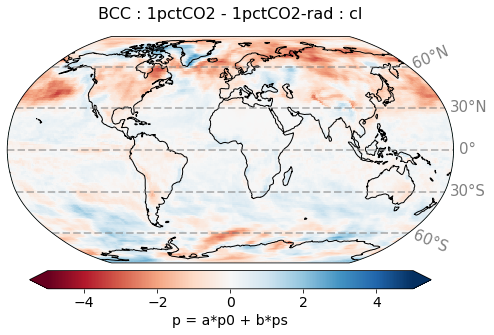

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'BCC : 1pctCO2 - 1pctCO2-rad : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f257b754460>)

In [14]:
map_data_bcc_diff = map_data_bcc_full - map_data_bcc_Rad
quick_map(map_data_bcc_diff, map_data_bcc_diff.lat, map_data_bcc_diff.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "BCC : 1pctCO2 - 1pctCO2-rad : cl", cb_ttl = "p = a*p0 + b*ps")

## BCC : 1pctCO2-BCG

In [15]:
cmip_dict['1pctCO2-bgc'].keys() # lists the modeling centers that have data for the '1pctCO2' experiment
ds_bcc_bgc = cmip_dict['1pctCO2-bgc']['BCC'] # Retrieves the dataset (ds) corresponding to the IPSL model under the '1pctCO2' scenario.
ds_bcc_bgc # to see the data inside the model

<xarray.Dataset>
Dimensions:    (time: 1812, bnds: 2, lev: 46, lat: 160, lon: 320)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
  * lev        (lev) float64 0.9926 0.9751 0.9479 ... 0.004959 0.003251 0.00198
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(180, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    p0         (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    a          (time, lev) float64 dask.array<chunksize=(180, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(180, 1), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(180, 160, 320), meta=np.ndarray>
    a_bnds     (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(180, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(180, 160, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(180, 320, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(180, 1, 160, 320), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          branch
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                CO2 concentration is prescribed by increasing at ...
    ...                     ...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/eeb35dab-6827-4741-a72e-6c78a3e71ad1
    variable_id:            cl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by BCC is licensed unde...
    cmor_version:           3.3.2

In [16]:
cl_below700_bcc_bgc = ds_bcc_bgc['cl'].isel(lev=slice(0, 7)).mean('lev')
cl_year_bcc_bgc = cl_below700_bcc_bgc.groupby("time.year").mean("time")
# cl_year

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


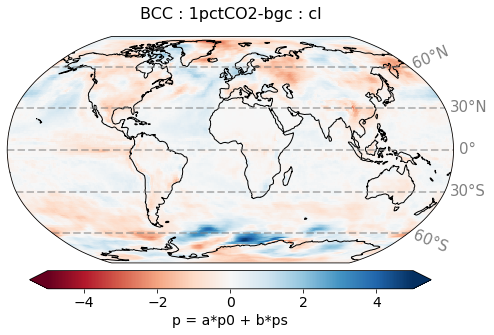

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'BCC : 1pctCO2-bgc : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f257b754460>)

In [17]:
map_data_bcc_bgc = (cl_year_bcc_bgc.isel(year=slice(130,150)).mean("year")-cl_year_bcc_bgc.isel(year=slice(1,21)).mean("year")).load() # load the data into this variable
quick_map(map_data_bcc_bgc, map_data_bcc_bgc.lat, map_data_bcc_bgc.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "BCC : 1pctCO2-bgc : cl", cb_ttl = "p = a*p0 + b*ps")

## CNRM-CERFACS : 1pctCO2 - 1pctCO2-rad

In [18]:
ds_cnrm_full = cmip_dict['1pctCO2']['CNRM-CERFACS']
ds_cnrm_full

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, lev: 91, time: 1800, axis_nbounds: 2,
                  bnds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lev          (lev) float64 0.9988 0.9959 0.992 ... 2.951e-05 9.869e-06
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:...
Dimensions without coordinates: axis_nbounds, bnds
Data variables:
    lev_bounds   (time, lev, axis_nbounds) float64 dask.array<chunksize=(1200, 1, 2), meta=np.ndarray>
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    cl           (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 128, 256), meta=np.ndarray>
    ps           (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
    ap           (time, lev) float64 dask.array<chunksize=(1200, 1), meta=np.ndarray>
    b            (time, lev) float64 dask.array<chunksize=(1200, 1), meta=np.ndarray>
    b_bnds       (time, bnds, lev) float64 dask.array<chunksize=(1200, 2, 1), meta=np.ndarray>
    ap_bnds      (time, bnds, lev) float64 dask.array<chunksize=(1200, 2, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-06-10T21:34:40Z
    description:            DECK: 1pctCO2
    title:                  CNRM-ESM2-1 model output prepared for CMIP6 / CMI...
    activity_id:            CMIP
    contact:                contact.cmip@meteo.fr
    ...                     ...
    dr2xml_md5sum:          789c0010d555326fb79e73c3e20c5d0e
    xios_commit:            1442-shuffle
    nemo_gelato_commit:     49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:   6.3.2
    tracking_id:            hdl:21.14100/bbd5da8f-1f3e-4942-b686-1f057ec1d908
    history:                none

In [19]:
cl_below700_cnrm_full = ds_cnrm_full['cl'].isel(lev=slice(0, 21)).mean('lev')
cl_year_cnrm_full = cl_below700_cnrm_full.groupby("time.year").mean("time")
# cl_year_cnrm_full

In [20]:
map_data_cnrm_full = cl_year_cnrm_full.isel(year=slice(130,150)).mean("year") - cl_year_cnrm_full.isel(year=slice(1,21)).mean("year")
# quick_map(map_data, map_data.lat, map_data.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "BCC cl", cb_ttl = "p = a*p0 + b*ps")

In [21]:
ds_cnrm_rad = cmip_dict['1pctCO2-rad']['CNRM-CERFACS']
ds_cnrm_rad

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, lev: 91, time: 1680, axis_nbounds: 2,
                  bnds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lev          (lev) float64 0.9988 0.9959 0.992 ... 2.951e-05 9.869e-06
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1989-12-16T12:...
Dimensions without coordinates: axis_nbounds, bnds
Data variables:
    lev_bounds   (time, lev, axis_nbounds) float64 dask.array<chunksize=(1200, 1, 2), meta=np.ndarray>
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    cl           (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 128, 256), meta=np.ndarray>
    ps           (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
    ap           (time, lev) float64 dask.array<chunksize=(1200, 1), meta=np.ndarray>
    b            (time, lev) float64 dask.array<chunksize=(1200, 1), meta=np.ndarray>
    b_bnds       (time, bnds, lev) float64 dask.array<chunksize=(1200, 2, 1), meta=np.ndarray>
    ap_bnds      (time, bnds, lev) float64 dask.array<chunksize=(1200, 2, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-06-12T12:16:48Z
    description:            Radiatively-coupled specified concentration simul...
    title:                  CNRM-ESM2-1 model output prepared for CMIP6 / C4M...
    activity_id:            C4MIP
    contact:                contact.cmip@meteo.fr
    ...                     ...
    dr2xml_md5sum:          789c0010d555326fb79e73c3e20c5d0e
    xios_commit:            1442-shuffle
    nemo_gelato_commit:     49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:   6.3.2
    tracking_id:            hdl:21.14100/54f536ba-4217-4b05-a766-cad756474670
    history:                none

In [22]:
cl_below700_cnrm_rad = ds_cnrm_rad['cl'].isel(lev=slice(0, 21)).mean('lev')
cl_year_cnrm_rad = cl_below700_cnrm_rad.groupby("time.year").mean("time")

In [23]:
map_data_cnrm_rad = cl_year_cnrm_rad.isel(year=slice(130,150)).mean("year")-cl_year_cnrm_rad.isel(year=slice(1,21)).mean("year")

In [24]:
map_data_cnrm_diff = map_data_cnrm_full - map_data_cnrm_rad

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


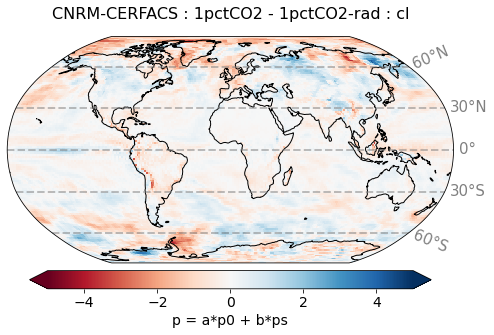

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'CNRM-CERFACS : 1pctCO2 - 1pctCO2-rad : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f257b754460>)

In [25]:
# THIS IS TAKING TOO LONG TO RUN
quick_map(map_data_cnrm_diff, map_data_cnrm_diff.lat, map_data_cnrm_diff.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "CNRM-CERFACS : 1pctCO2 - 1pctCO2-rad : cl", cb_ttl = "p = a*p0 + b*ps")

## CNRM-CERFACS : 1pctCO2-bgc

In [6]:
ds_cnrm_bgc = cmip_dict['1pctCO2-bgc']['CNRM-CERFACS']
ds_cnrm_bgc

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, lev: 91, time: 1680, axis_nbounds: 2,
                  bnds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lev          (lev) float64 0.9988 0.9959 0.992 ... 2.951e-05 9.869e-06
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1989-12-16T12:...
Dimensions without coordinates: axis_nbounds, bnds
Data variables:
    lev_bounds   (time, lev, axis_nbounds) float64 dask.array<chunksize=(1200, 1, 2), meta=np.ndarray>
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    cl           (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 128, 256), meta=np.ndarray>
    ps           (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
    ap           (time, lev) float64 dask.array<chunksize=(1200, 1), meta=np.ndarray>
    b            (time, lev) float64 dask.array<chunksize=(1200, 1), meta=np.ndarray>
    b_bnds       (time, bnds, lev) float64 dask.array<chunksize=(1200, 2, 1), meta=np.ndarray>
    ap_bnds      (time, bnds, lev) float64 dask.array<chunksize=(1200, 2, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-06-09T08:35:02Z
    description:            Biogeochemically-coupled specified concentration ...
    title:                  CNRM-ESM2-1 model output prepared for CMIP6 / C4M...
    activity_id:            C4MIP
    contact:                contact.cmip@meteo.fr
    ...                     ...
    dr2xml_md5sum:          789c0010d555326fb79e73c3e20c5d0e
    xios_commit:            1442-shuffle
    nemo_gelato_commit:     49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:   6.3.2
    tracking_id:            hdl:21.14100/a7e3a31f-b7b9-4d4e-bad1-27a49ba5665e
    history:                none

In [7]:
cl_below700_cnrm_bgc = ds_cnrm_bgc['cl'].isel(lev=slice(0, 21)).mean('lev')
cl_year_cnrm_bgc = cl_below700_cnrm_bgc.groupby("time.year").mean("time")
# cl_year

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


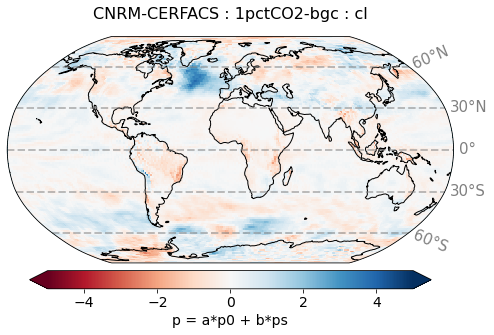

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'CNRM-CERFACS : 1pctCO2-bgc : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3b443eb910>)

In [9]:
map_data_cnrm_bgc = cl_year_cnrm_bgc.isel(year=slice(130,150)).mean("year")-cl_year_cnrm_bgc.isel(year=slice(1,21)).mean("year")
quick_map(map_data_cnrm_bgc, map_data_cnrm_bgc.lat, map_data_cnrm_bgc.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "CNRM-CERFACS : 1pctCO2-bgc : cl", cb_ttl = "p = a*p0 + b*ps")

## CSIRO : 1pctCO2 - 1pctCO2-rad

In [6]:
ds_csiro_full = cmip_dict['1pctCO2']['CSIRO']
ds_csiro_full

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 38, lat: 145, lon: 192)
Coordinates:
  * time       (time) object 0101-01-16 12:00:00 ... 0250-12-16 12:00:00
  * lev        (lev) float64 20.0 80.0 180.0 ... 2.922e+04 3.291e+04 3.925e+04
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(240, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    orog       (time, lat, lon) float32 dask.array<chunksize=(240, 145, 192), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(240, 145, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(240, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(240, 1, 145, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-15T04:30:58Z
    ...                     ...
    variable_id:            cl
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/909ea171-bada-4506-be68-6fbd98d1d1e0
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [7]:
cl_below700_csiro_full = ds_csiro_full['cl'].isel(lev=slice(0, 12)).mean('lev')
cl_year_csiro_full = cl_below700_csiro_full.groupby("time.year").mean("time")

In [8]:
map_data_csiro_full = cl_year_csiro_full.isel(year=slice(130,150)).mean("year")-cl_year_csiro_full.isel(year=slice(1,21)).mean("year")

In [9]:
ds_csiro_rad = cmip_dict['1pctCO2-rad']['CSIRO']
ds_csiro_rad

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 38, lat: 145, lon: 192)
Coordinates:
  * time       (time) object 0101-01-16 12:00:00 ... 0250-12-16 12:00:00
  * lev        (lev) float64 20.0 80.0 180.0 ... 2.922e+04 3.291e+04 3.925e+04
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(240, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    orog       (time, lat, lon) float32 dask.array<chunksize=(240, 145, 192), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(240, 145, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(240, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(240, 1, 145, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-18T05:10:44Z
    ...                     ...
    variable_id:            cl
    variant_label:          r1i1p1f1
    version:                v20191118
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/794162e1-88dd-4cba-ab72-52b9132faf6f
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [10]:
cl_below700_csiro_rad = ds_csiro_rad['cl'].isel(lev=slice(0, 12)).mean('lev')
cl_year_csiro_rad = cl_below700_csiro_rad.groupby("time.year").mean("time")

In [11]:
map_data_csiro_rad = cl_year_csiro_rad.isel(year=slice(130,150)).mean("year")-cl_year_csiro_rad.isel(year=slice(1,21)).mean("year")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


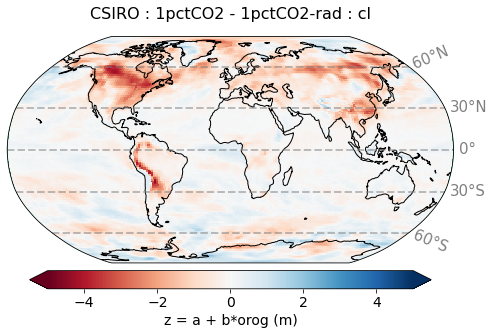

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'CSIRO : 1pctCO2 - 1pctCO2-rad : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7ff7e2a03790>)

In [12]:
map_data_csiro_diff = map_data_csiro_full - map_data_csiro_rad
quick_map(map_data_csiro_diff, map_data_csiro_diff.lat, map_data_csiro_diff.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "CSIRO : 1pctCO2 - 1pctCO2-rad : cl", cb_ttl = "z = a + b*orog (m)")

## CSIRO : 1pctCO2-bgc

In [13]:
ds_csiro_bgc = cmip_dict['1pctCO2-rad']['CSIRO']
ds_csiro_bgc

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 38, lat: 145, lon: 192)
Coordinates:
  * time       (time) object 0101-01-16 12:00:00 ... 0250-12-16 12:00:00
  * lev        (lev) float64 20.0 80.0 180.0 ... 2.922e+04 3.291e+04 3.925e+04
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(240, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    orog       (time, lat, lon) float32 dask.array<chunksize=(240, 145, 192), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(240, 145, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(240, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(240, 1, 145, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-18T05:10:44Z
    ...                     ...
    variable_id:            cl
    variant_label:          r1i1p1f1
    version:                v20191118
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/794162e1-88dd-4cba-ab72-52b9132faf6f
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [14]:
cl_below700_csiro_bgc = ds_csiro_bgc['cl'].isel(lev=slice(0, 12)).mean('lev')
cl_year_csiro_bgc = cl_below700_csiro_bgc.groupby("time.year").mean("time")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


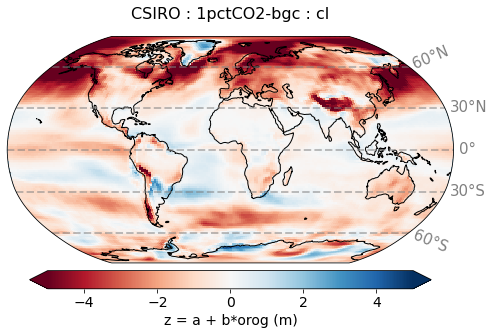

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'CSIRO : 1pctCO2-bgc : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7ff7e2a03790>)

In [15]:
map_data_csiro_bgc = (cl_year_csiro_bgc.isel(year=slice(130,150)).mean("year")-cl_year_csiro_bgc.isel(year=slice(1,21)).mean("year")).load()
quick_map(map_data_csiro_bgc, map_data_csiro_bgc.lat, map_data_csiro_bgc.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "CSIRO : 1pctCO2-bgc : cl", cb_ttl = "z = a + b*orog (m)")

## IPSL : 1pctCO2 - 1pctCO2-rad

In [9]:
ds_ipsl_full = cmip_dict['1pctCO2']['IPSL']
ds_ipsl_full

<xarray.Dataset>
Dimensions:      (lat: 143, lon: 144, presnivs: 79, klevp1: 80, bnds: 2,
                  time: 1800, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    cl           (time, presnivs, lat, lon) float32 dask.array<chunksize=(600, 1, 143, 144), meta=np.ndarray>
    ps           (time, lat, lon) float32 dask.array<chunksize=(600, 143, 144), meta=np.ndarray>
    ap           (klevp1) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    b            (klevp1) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    b_bnds       (bnds, klevp1) float64 dask.array<chunksize=(2, 80), meta=np.ndarray>
    ap_bnds      (bnds, klevp1) float64 dask.array<chunksize=(2, 80), meta=np.ndarray>
Attributes: (12/51)
    name:                   /ccc/work/cont003/gencmip6/p86maf/IGCM_OUT/IPSLCM...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-05-02T16:56:20Z
    description:            DECK: 1pctCO2
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    activity_id:            CMIP
    ...                     ...
    EXPID:                  1pctCO2
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          00e1a4f623b35a33620b9828c66bd1c8
    model_version:          6.1.2
    tracking_id:            hdl:21.14100/414e325c-2740-4f43-a32a-fe43c1fa0276
    history:                Thu Jul 26 18:43:57 2018: ncatted -O -a tracking_...

In [10]:
cl_below700_ipsl_full = ds_ipsl_full['cl'].isel(presnivs=slice(0, 27)).mean('presnivs')
cl_year_ipsl_full = cl_below700_ipsl_full.groupby("time.year").mean("time")

In [11]:
map_data_ipsl_full = cl_year_ipsl_full.isel(year=slice(130,150)).mean("year")-cl_year_ipsl_full.isel(year=slice(1,21)).mean("year")

In [12]:
ds_ipsl_rad = cmip_dict['1pctCO2-rad']['IPSL']
ds_ipsl_rad

<xarray.Dataset>
Dimensions:      (lat: 143, lon: 144, presnivs: 79, klevp1: 80, bnds: 2,
                  time: 1800, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    cl           (time, presnivs, lat, lon) float32 dask.array<chunksize=(600, 1, 143, 144), meta=np.ndarray>
    ps           (time, lat, lon) float32 dask.array<chunksize=(600, 143, 144), meta=np.ndarray>
    ap           (klevp1) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    b            (klevp1) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    b_bnds       (bnds, klevp1) float64 dask.array<chunksize=(2, 80), meta=np.ndarray>
    ap_bnds      (bnds, klevp1) float64 dask.array<chunksize=(2, 80), meta=np.ndarray>
Attributes: (12/50)
    name:                   /ccc/work/cont003/gencmip6/p86cadul/IGCM_OUT/IPSL...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-05-30T17:03:38Z
    tracking_id:            hdl:21.14100/f8b8ef15-1b54-403d-9458-de24899ecd40
    description:            Radiatively-coupled specified concentration simul...
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / C4...
    ...                     ...
    variable_id:            cl
    variant_label:          r1i1p1f1
    EXPID:                  1pctCO2-rad
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          f91de4d48022fecbbf24061748ee64ec
    model_version:          6.1.3

In [13]:
cl_below700_ipsl_rad = ds_ipsl_rad['cl'].isel(presnivs=slice(0, 27)).mean('presnivs')
cl_year_ipsl_rad = cl_below700_ipsl_rad.groupby("time.year").mean("time")

In [14]:
map_data_ipsl_rad = cl_year_ipsl_rad.isel(year=slice(130,150)).mean("year")-cl_year_ipsl_rad.isel(year=slice(1,21)).mean("year")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


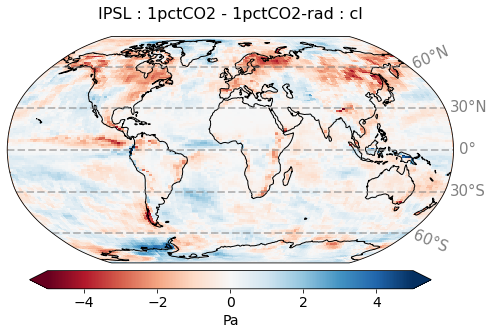

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'IPSL : 1pctCO2 - 1pctCO2-rad : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3706813910>)

In [15]:
map_data_ipsl_diff = map_data_ipsl_full - map_data_ipsl_rad
quick_map(map_data_ipsl_diff, map_data_ipsl_diff.lat, map_data_ipsl_diff.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "IPSL : 1pctCO2 - 1pctCO2-rad : cl", cb_ttl = "Pa")

## IPSL : 1pctCO2-bgc

In [16]:
ds_ipsl_bgc = cmip_dict['1pctCO2-rad']['IPSL']
ds_ipsl_bgc

<xarray.Dataset>
Dimensions:      (lat: 143, lon: 144, presnivs: 79, klevp1: 80, bnds: 2,
                  time: 1800, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * presnivs     (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    cl           (time, presnivs, lat, lon) float32 dask.array<chunksize=(600, 1, 143, 144), meta=np.ndarray>
    ps           (time, lat, lon) float32 dask.array<chunksize=(600, 143, 144), meta=np.ndarray>
    ap           (klevp1) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    b            (klevp1) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    b_bnds       (bnds, klevp1) float64 dask.array<chunksize=(2, 80), meta=np.ndarray>
    ap_bnds      (bnds, klevp1) float64 dask.array<chunksize=(2, 80), meta=np.ndarray>
Attributes: (12/50)
    name:                   /ccc/work/cont003/gencmip6/p86cadul/IGCM_OUT/IPSL...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-05-30T17:03:38Z
    tracking_id:            hdl:21.14100/f8b8ef15-1b54-403d-9458-de24899ecd40
    description:            Radiatively-coupled specified concentration simul...
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / C4...
    ...                     ...
    variable_id:            cl
    variant_label:          r1i1p1f1
    EXPID:                  1pctCO2-rad
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          f91de4d48022fecbbf24061748ee64ec
    model_version:          6.1.3

In [17]:
cl_below700_ipsl_bgc = ds_ipsl_bgc['cl'].isel(presnivs=slice(0, 27)).mean('presnivs')
cl_year_ipsl_bgc = cl_below700_ipsl_bgc.groupby("time.year").mean("time")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


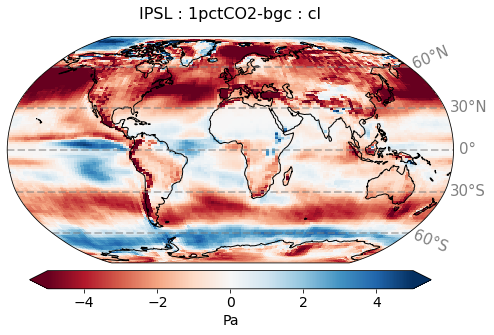

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'IPSL : 1pctCO2-bgc : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3706813910>)

In [18]:
map_data_ipsl_bgc = (cl_year_ipsl_bgc.isel(year=slice(130,150)).mean("year")-cl_year_ipsl_bgc.isel(year=slice(1,21)).mean("year")).load()
quick_map(map_data_ipsl_bgc, map_data_ipsl_bgc.lat, map_data_ipsl_bgc.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "IPSL : 1pctCO2-bgc : cl", cb_ttl = "Pa")

## MIROC : 1pctCO2 - 1pctCO2-rad

In [19]:
ds_miroc_full = cmip_dict['1pctCO2']['MIROC']
ds_miroc_full

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 40, lat: 64, lon: 128)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
  * lev        (lev) float64 0.9975 0.9915 0.983 ... 0.01861 0.0106 0.002905
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    p0         float64 ...
    a          (lev) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(600, 64, 128), meta=np.ndarray>
    a_bnds     (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    b_bnds     (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 64, 128), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-07-02T08:11:28Z
    ...                     ...
    title:                  MIROC-ES2L output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by MIROC is licensed un...
    cmor_version:           3.3.2
    tracking_id:            hdl:21.14100/75441516-6538-4685-9dcb-4644d57c0f8a

In [20]:
cl_below700_miroc_full = ds_miroc_full['cl'].isel(lev=slice(0, 14)).mean('lev')
cl_year_miroc_full = cl_below700_miroc_full.groupby("time.year").mean("time")

In [21]:
map_data_miroc_full = cl_year_miroc_full.isel(year=slice(130,150)).mean("year")-cl_year_miroc_full.isel(year=slice(1,21)).mean("year")

In [22]:
ds_miroc_rad = cmip_dict['1pctCO2-rad']['MIROC']
ds_miroc_rad

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 40, lat: 64, lon: 128)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
  * lev        (lev) float64 0.9975 0.9915 0.983 ... 0.01861 0.0106 0.002905
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    p0         float64 ...
    a          (lev) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(600, 64, 128), meta=np.ndarray>
    a_bnds     (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    b_bnds     (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 64, 128), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-14T05:34:43Z
    ...                     ...
    title:                  MIROC-ES2L output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by MIROC is licensed un...
    cmor_version:           3.3.2
    tracking_id:            hdl:21.14100/dfb5b687-995e-41bc-b0f5-264ee29f6cc7

In [23]:
cl_below700_miroc_rad = ds_miroc_rad['cl'].isel(lev=slice(0, 14)).mean('lev')
cl_year_miroc_rad = cl_below700_miroc_rad.groupby("time.year").mean("time")

In [24]:
map_data_miroc_rad = cl_year_miroc_rad.isel(year=slice(130,150)).mean("year")-cl_year_miroc_rad.isel(year=slice(1,21)).mean("year")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


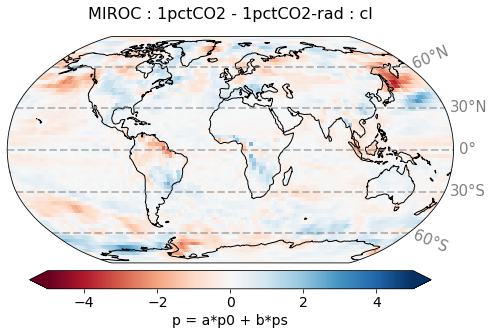

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'MIROC : 1pctCO2 - 1pctCO2-rad : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3706813910>)

In [25]:
map_data_miroc_diff = map_data_miroc_full - map_data_miroc_rad
quick_map(map_data_miroc_diff, map_data_miroc_diff.lat, map_data_miroc_diff.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "MIROC : 1pctCO2 - 1pctCO2-rad : cl", cb_ttl = "p = a*p0 + b*ps")

## MIROC : 1pctCO2-bgc

In [26]:
ds_miroc_bgc = cmip_dict['1pctCO2-bgc']['MIROC']
ds_miroc_bgc

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 40, lat: 64, lon: 128)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00
  * lev        (lev) float64 0.9975 0.9915 0.983 ... 0.01861 0.0106 0.002905
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    p0         float64 ...
    a          (lev) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(600, 64, 128), meta=np.ndarray>
    a_bnds     (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    b_bnds     (lev, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 64, 128), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-14T05:26:50Z
    ...                     ...
    title:                  MIROC-ES2L output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by MIROC is licensed un...
    cmor_version:           3.3.2
    tracking_id:            hdl:21.14100/f6a87397-a61d-42f1-b32b-2c610a7a6162

In [27]:
cl_below700_miroc_bgc = ds_miroc_bgc['cl'].isel(lev=slice(0, 14)).mean('lev')
cl_year_miroc_bgc = cl_below700_miroc_bgc.groupby("time.year").mean("time")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


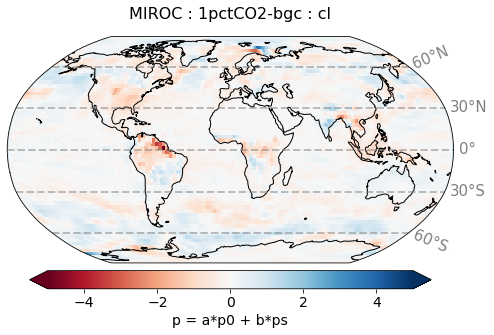

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'MIROC : 1pctCO2-bgc : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3706813910>)

In [28]:
map_data_miroc_bgc = (cl_year_miroc_bgc.isel(year=slice(130,150)).mean("year")-cl_year_miroc_bgc.isel(year=slice(1,21)).mean("year")).load()
quick_map(map_data_miroc_bgc, map_data_miroc_bgc.lat, map_data_miroc_bgc.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "MIROC : 1pctCO2-bgc : cl", cb_ttl = "p = a*p0 + b*ps")

## MOHC : 1pctCO2 - 1pctCO2-rad

In [29]:
ds_mohc_full = cmip_dict['1pctCO2']['MOHC']
ds_mohc_full

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 85, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 1999-12-16 00:00:00
  * lev        (lev) float64 20.0 53.33 100.0 ... 7.378e+04 7.91e+04 8.5e+04
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    orog       (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(600, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 144, 192), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  39600.0
    creation_date:          2019-04-05T16:33:53Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/d688c33c-0b46-4d62-ad7d-be2ddd5d32ca

In [60]:
cl_below700_mohc_full = ds_mohc_full['cl'].isel(lev=slice(0, 20)).mean('lev')
cl_year_mohc_full = cl_below700_mohc_full.groupby("time.year").mean("time")

In [61]:
map_data_mohc_full = cl_year_mohc_full.isel(year=slice(130,150)).mean("year")-cl_year_mohc_full.isel(year=slice(1,21)).mean("year")

In [62]:
ds_mohc_rad = cmip_dict['1pctCO2-rad']['MOHC']
ds_mohc_rad

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 85, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 1999-12-16 00:00:00
  * lev        (lev) float64 20.0 53.33 100.0 ... 7.378e+04 7.91e+04 8.5e+04
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    orog       (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(600, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 144, 192), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  39600.0
    creation_date:          2019-07-18T20:46:55Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/ac86d7a5-492e-4153-994b-b208ae078c17

In [63]:
cl_below700_mohc_rad = ds_mohc_rad['cl'].isel(lev=slice(0, 20)).mean('lev')
cl_year_mohc_rad = cl_below700_mohc_rad.groupby("time.year").mean("time")

In [64]:
map_data_mohc_rad = cl_year_mohc_rad.isel(year=slice(130,150)).mean("year")-cl_year_mohc_rad.isel(year=slice(1,21)).mean("year")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


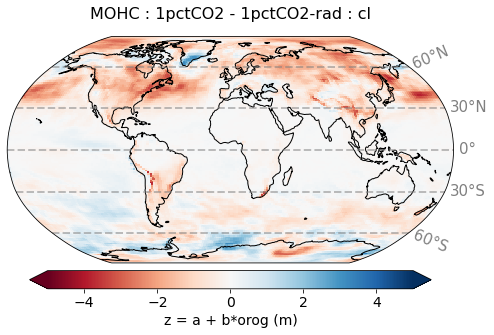

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'MOHC : 1pctCO2 - 1pctCO2-rad : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3706813910>)

In [65]:
map_data_mohc_diff = map_data_mohc_full - map_data_mohc_rad
quick_map(map_data_mohc_diff, map_data_mohc_diff.lat, map_data_mohc_diff.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "MOHC : 1pctCO2 - 1pctCO2-rad : cl", cb_ttl = "z = a + b*orog (m)")

## MOHC : 1pctCO2-bgc

In [66]:
ds_mohc_bgc = cmip_dict['1pctCO2-bgc']['MOHC']
ds_mohc_bgc

<xarray.Dataset>
Dimensions:    (time: 1800, bnds: 2, lev: 85, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 1999-12-16 00:00:00
  * lev        (lev) float64 20.0 53.33 100.0 ... 7.378e+04 7.91e+04 8.5e+04
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    orog       (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(600, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 144, 192), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  39600.0
    creation_date:          2019-07-18T20:52:58Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/a84c2fda-004a-4a17-91bb-1b960d970ab8

In [67]:
cl_below700_mohc_bgc = ds_mohc_bgc['cl'].isel(lev=slice(0, 20)).mean('lev')
cl_year_mohc_bgc = cl_below700_mohc_bgc.groupby("time.year").mean("time")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


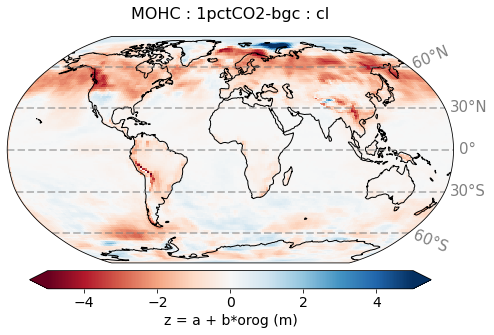

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'MOHC : 1pctCO2-bgc : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3706813910>)

In [68]:
map_data_mohc_bgc = cl_year_mohc_bgc.isel(year=slice(130,150)).mean("year")-cl_year_mohc_bgc.isel(year=slice(1,21)).mean("year")
quick_map(map_data_mohc_bgc, map_data_mohc_bgc.lat, map_data_mohc_bgc.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "MOHC : 1pctCO2-bgc : cl", cb_ttl = "z = a + b*orog (m)")

## MPI-M : 1pctCO2 - 1pctCO2-rad

In [16]:
ds_mpi_full = cmip_dict['1pctCO2']['MPI-M']
ds_mpi_full

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lev: 47, lat: 96, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lev        (lev) float64 0.9961 0.9826 0.959 ... 4.225e-05 9.816e-06
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    ap         (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(240, 96, 192), meta=np.ndarray>
    ap_bnds    (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(240, 96, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(240, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(240, 1, 96, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/111254df-9eec-4ac2-bd95-a7c6795bb9db

In [17]:
cl_below700_mpi_full = ds_mpi_full['cl'].isel(lev=slice(0, 9)).mean('lev')
cl_year_mpi_full = cl_below700_mpi_full.groupby("time.year").mean("time")

In [18]:
map_data_mpi_full = cl_year_mpi_full.isel(year=slice(130,150)).mean("year")-cl_year_mpi_full.isel(year=slice(1,21)).mean("year")

In [19]:
ds_mpi_rad = cmip_dict['1pctCO2-rad']['MPI-M']
ds_mpi_rad

<xarray.Dataset>
Dimensions:    (time: 1680, bnds: 2, lev: 47, lat: 96, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1989-12-16T12:00:00
  * lev        (lev) float64 0.9961 0.9826 0.959 ... 4.225e-05 9.816e-06
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    ap         (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(240, 96, 192), meta=np.ndarray>
    ap_bnds    (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(240, 96, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(240, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(240, 1, 96, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/be2a7973-0fa0-45bb-a310-b4cb6b641029

In [20]:
cl_below700_mpi_rad = ds_mpi_rad['cl'].isel(lev=slice(0, 9)).mean('lev')
cl_year_mpi_rad = cl_below700_mpi_rad.groupby("time.year").mean("time")

In [21]:
map_data_mpi_rad = cl_year_mpi_rad.isel(year=slice(130,150)).mean("year")-cl_year_mpi_rad.isel(year=slice(1,21)).mean("year")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


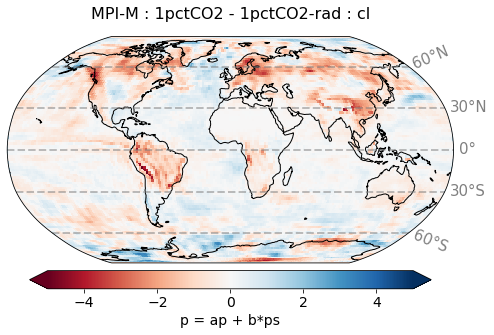

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'MPI-M : 1pctCO2 - 1pctCO2-rad : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7ff7e2a03790>)

In [22]:
map_data_mpi_diff = map_data_mpi_full - map_data_mpi_rad
quick_map(map_data_mpi_diff, map_data_mpi_diff.lat, map_data_mpi_diff.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "MPI-M : 1pctCO2 - 1pctCO2-rad : cl", cb_ttl = "p = ap + b*ps")

## MPI-M : 1pctCO2-bgc

In [47]:
ds_mpi_bgc = cmip_dict['1pctCO2-bgc']['MPI-M']
ds_mpi_bgc

<xarray.Dataset>
Dimensions:    (time: 1680, bnds: 2, lev: 47, lat: 96, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1989-12-16T12:00:00
  * lev        (lev) float64 0.9961 0.9826 0.959 ... 4.225e-05 9.816e-06
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    ap         (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(240, 96, 192), meta=np.ndarray>
    ap_bnds    (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(240, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(240, 96, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(240, 192, 2), meta=np.ndarray>
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(240, 1, 96, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            cl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/dd4df3fc-cbc3-461e-a97f-1b0d1ce815f1

In [48]:
cl_below700_mpi_bgc = ds_mpi_bgc['cl'].isel(lev=slice(0, 9)).mean('lev')
cl_year_mpi_bgc = cl_below700_mpi_bgc.groupby("time.year").mean("time")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


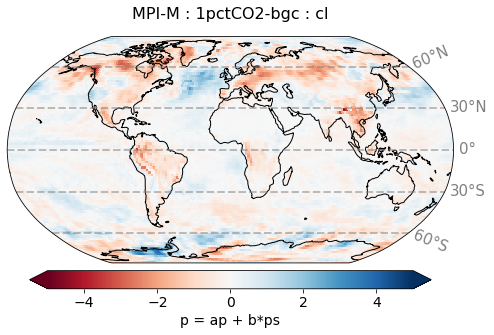

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'MPI-M : 1pctCO2-bgc : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3706813910>)

In [49]:
map_data_mpi_bgc = cl_year_mpi_bgc.isel(year=slice(130,150)).mean("year")-cl_year_mpi_bgc.isel(year=slice(1,21)).mean("year")
quick_map(map_data_mpi_bgc, map_data_mpi_bgc.lat, map_data_mpi_bgc.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "MPI-M : 1pctCO2-bgc : cl", cb_ttl = "p = ap + b*ps")

## NCAR : 1pctCO2 - 1pctCO2-rad

In [28]:
# ERROR HERE
ds_ncar_full = cmip_dict['1pctCO2']['NCAR']
ds_ncar_full

<xarray.Dataset>
Dimensions:    (time: 1800, lev: 32, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 0001-01-15 12:00:00 ... 0150-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 192, 288), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    p0         (time) float32 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    a          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    b_bnds     (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(600, 288, 2), meta=np.ndarray>
    lev_bnds   (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    a_bnds     (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  182500.0
    case_id:                58
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/9d0177a7-1d6f-4373-9a26-d3ed37144e67
    variable_id:            cl
    variant_info:           CMIP6 CESM2 1pctCO2 experiment with interactive a...
    variant_label:          r1i1p1f1

In [29]:
cl_below700_ncar_full = ds_ncar_full['cl'].isel(lev=slice(21, None)).mean('lev')
cl_year_ncar_full = cl_below700_ncar_full.groupby("time.year").mean("time")

In [30]:
map_data_ncar_full = cl_year_ncar_full.isel(year=slice(130,150)).mean("year")-cl_year_ncar_full.isel(year=slice(1,21)).mean("year")

In [31]:
ds_ncar_rad = cmip_dict['1pctCO2-rad']['NCAR']
ds_ncar_rad

<xarray.Dataset>
Dimensions:    (time: 1800, lev: 32, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 0001-01-15 12:00:00 ... 0150-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 192, 288), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    p0         (time) float32 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    a          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    b_bnds     (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(600, 288, 2), meta=np.ndarray>
    lev_bnds   (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    a_bnds     (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  182500.0
    case_id:                1618
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/750e6851-c404-43cd-bac6-7abf195ae0ae
    variable_id:            cl
    variant_info:           Radiatively-coupled version of 1% per year increa...
    variant_label:          r1i1p1f1

In [32]:
cl_below700_ncar_rad = ds_ncar_rad['cl'].isel(lev=slice(0, 9)).mean('lev')
cl_year_ncar_rad = cl_below700_ncar_rad.groupby("time.year").mean("time")

In [33]:
map_data_ncar_rad = cl_year_ncar_rad.isel(year=slice(130,150)).mean("year")-cl_year_ncar_rad.isel(year=slice(1,21)).mean("year")

In [ ]:
map_data_ncar_diff = map_data_ncar_full - map_data_ncar_rad
quick_map(map_data_ncar_diff, map_data_ncar_diff.lat, map_data_ncar_diff.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "NCAR : 1pctCO2 - 1pctCO2-rad : cl", cb_ttl = "p = ap + b*ps")

## NCAR : 1pctCO2-bgc

In [57]:
ds_ncar_bgc = cmip_dict['1pctCO2-bgc']['NCAR']
ds_ncar_bgc

<xarray.Dataset>
Dimensions:    (time: 1800, lev: 32, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 0001-01-15 12:00:00 ... 0150-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    cl         (time, lev, lat, lon) float32 dask.array<chunksize=(600, 1, 192, 288), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    p0         (time) float32 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    a          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(600, 1), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    b_bnds     (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(600, 288, 2), meta=np.ndarray>
    lev_bnds   (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    a_bnds     (time, lev, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  182500.0
    case_id:                59
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/d8e9d177-a8e2-463b-9444-2bfdeb55b99c
    variable_id:            cl
    variant_info:           Biogeochemically-coupled version of 1% per year i...
    variant_label:          r1i1p1f1

In [58]:
cl_below700_ncar_bgc = ds_ncar_bgc['cl'].isel(lev=slice(22, None)).mean('lev')
cl_year_ncar_bgc = cl_below700_ncar_bgc.groupby("time.year").mean("time")

/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/dana25/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


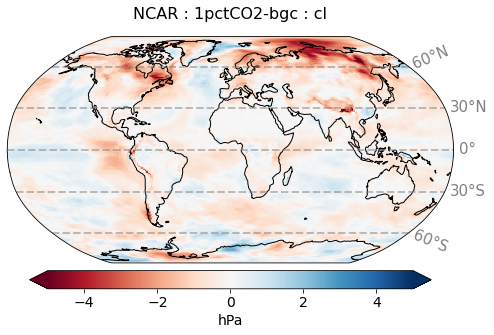

(<Figure size 576x504 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'NCAR : 1pctCO2-bgc : cl'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f3706813910>)

In [59]:
map_data_ncar_bgc = cl_year_ncar_bgc.isel(year=slice(130,150)).mean("year")-cl_year_ncar_bgc.isel(year=slice(1,21)).mean("year")
quick_map(map_data_ncar_bgc, map_data_ncar_bgc.lat, map_data_ncar_bgc.lon, cmap = plt.cm.RdBu, clim = [-5,5],show=True, title = "NCAR : 1pctCO2-bgc : cl", cb_ttl = "hPa")